# Dealing with massively imbalanced datasets for improved fraud detection

Use of synthetic data generation to balance highly imbalanced classes, in particular, generation of synthetic fraudulent events.

The use of synthetic data for this type of use cases helps to improve the accuracy of fraud detection models in many different areas from the banking industry.


### Machine Learning and imbalanced datasets
Highly imbalanced datasets are extremely challenging for data teams, and they can be found very often in the industry, wether in topics such as detecting fraudulent events, but also for money laundry and even credit underwriting.

The commonnality between each one of these use cases? The fact that only a small portion of the overall transactions represent one particular class, for fraud problems, only a portion of those transactions were, in reality, a fraudulent event.

## Credit Fraud - a highy imbalanced dataset
The dataset in this example use case is from Kaggle - ["Credit Card Fraud detection"](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset, as for demonstration purposes we are only able to use datasets from the public domain.
This dataset includes labeled transactions from European credit car holders, and the data provided is a result from a dimensionality reduction, containing 27 continous features and a time column - the number of secons elapsed between the first and the last transaction of the dataset.

### The dataset Exploratory data analysis
(Include here some input on how highly imbalanced are the datasets)

(Include here some metrics and some validations that where done using YData's lib for data analysis)


In [98]:
#Download the data from kaggle and read it using pandas
from datetime import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ydata.connectors import GCSConnector, LocalConnector
from ydata.connectors.filetype import FileType

#Aux function to read credentials from a json file
def read_credentials(path):
    credentials = {}

    with open(path, 'r') as f:
        credentials = json.load(f)

    return credentials

In [100]:
keyfile_dict = read_credentials('credentials/ydatasynthetic-8a44c2f31562.json')

gcs_connector = GCSConnector(project_id='ydatasynthetic',
                             keyfile_dict=keyfile_dict)

In [101]:
#Get the credit fraud dataset using ydata's GCS connector
credit = gcs_connector.read_file('gs://ydata_testdata/tabular/credit_fraud/data.csv', file_type=FileType.CSV)

In [102]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This dataset is highly imbalanced. Let's check the behaviour of the imbalanced classes.

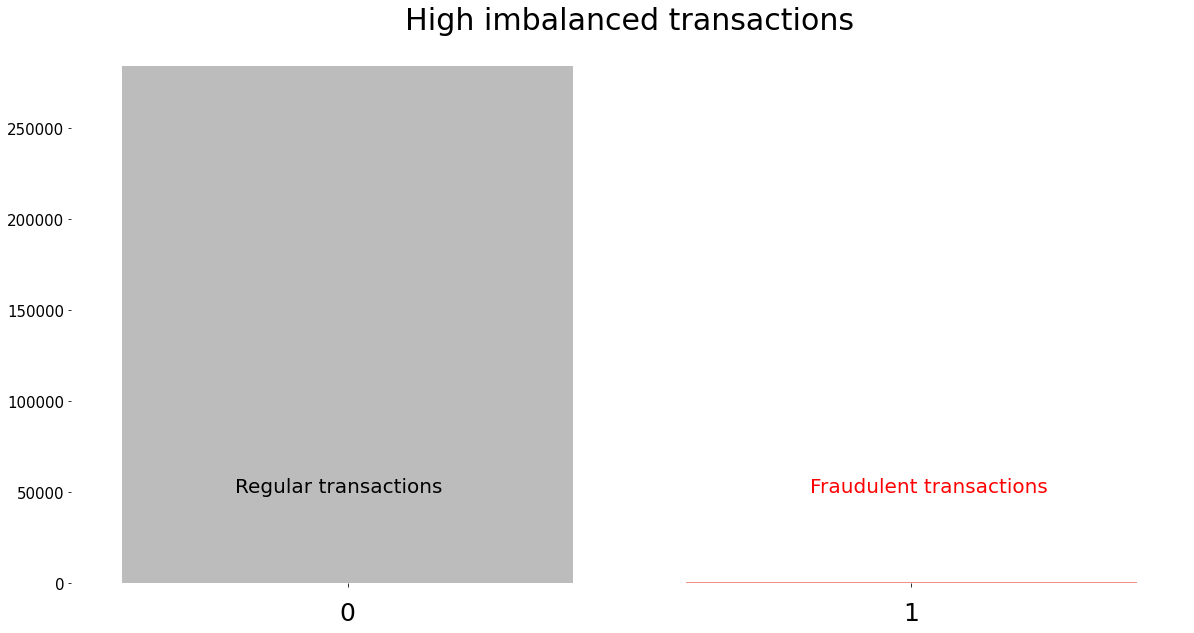

In [103]:
fig, ax = plt.subplots(figsize=(20,10))

#Remove the frame around
#Have this as an auxiliary function
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.bar([0, 1], pd.value_counts(credit['Class'].values, sort=True), alpha=0.5, color=['#7A7A7A','#E32212'])
plt.title('High imbalanced transactions', fontsize=30, pad=10)
plt.annotate('Fraudulent transactions', (0.82, 50000), fontsize=20, color='red')
plt.annotate('Regular transactions', (-0.2, 50000), fontsize=20, color='black')
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_ticks([0,1])
ax.tick_params(axis='x', which='major', pad=15)
ax.xaxis.set_tick_params(labelsize=25)

Text(0.5, 1.0, 'Scatter plot for V2 and V4 eigenvectors')

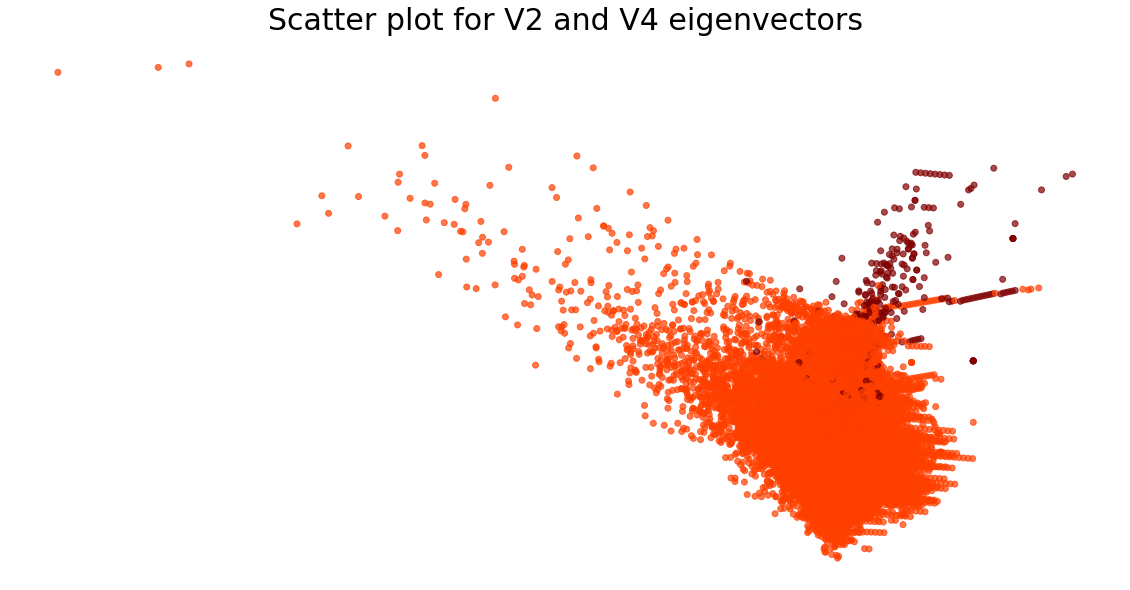

In [104]:
#Scatter plot with Class colouring the different elements from the plot
#As this dataset is the result of a PCA we will be using 2 eigen vectors for the plot
import matplotlib as m
import numpy as np

cmap = m.cm.jet(np.linspace(0,1,26))
cmap = m.colors.ListedColormap(cmap[21:,:-1])

fig, ax = plt.subplots(figsize=(20,10))

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.scatter(credit['V2'],credit['V4'], alpha=0.7, c=credit['Class'],cmap=cmap)
plt.axis('off')
plt.title('Scatter plot for V2 and V4 eigenvectors', fontsize=30, pad=10)

Splitting the dataset in train and test sets. The test set will be used again at the end of our iteration

In [105]:
X = credit.drop('Class', axis=1)
cols = X.columns
X = X.values
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807


In [106]:
#profile = ProfileReport(pd.DataFrame(X_train, columns=cols), title='Credit Card fraud', explorative=True)

In [107]:
count_original = np.unique(y, return_counts=True)
count_train = np.unique(y_train, return_counts=True)
count_test = np.unique(y_test, return_counts=True)

print("Ratio between fraud and normal events for the \033[1mfull\033[0m  dataset:"+ " {:.2}%".format(count_train[1][1]/count_train[1][0]))
print("Ratio between fraud and normal events for the \033[1mtrain\033[0m dataset:"+ " {:.2}%".format(count_train[1][1]/count_train[1][0]))
print("Ratio between fraud and normal events for the \033[1mtest\033[0m dataset:"+" {:.2}%".format(count_test[1][1]/count_test[1][0]))

Ratio between fraud and normal events for the full  dataset: 0.0017%
Ratio between fraud and normal events for the train dataset: 0.0017%
Ratio between fraud and normal events for the test dataset: 0.0017%


### The first model
Let's try to develop a model basedo n the assumption that everything is ok with our dataset, and understand how good is our classifier to indetify fraudulent events.
Here we've decided to develop a classifier using [RandomForest from the scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) package.

In [108]:
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

In [109]:
#Data scaling and preprocessing before training the model
from sklearn.preprocessing import RobustScaler, StandardScaler

def preprocess_df(df, std_scaler, rob_scaler):
    df['Amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
    return df

In [110]:
stdscaler = StandardScaler()
robscaler = RobustScaler()

X_train = preprocess_df(X_train, stdscaler, robscaler)

In [111]:
#Apply the same trasnformation to the test dataset
X_test = preprocess_df(X_test, stdscaler, robscaler)

In [15]:
#Using XGBOOST model to train the model
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


def XGBoost_Classifier(X, y, Xtest):
    """XGBoost training code"""
    classifier = XGBClassifier()
    print('Start fitting XGBoost classifier')
    classifier.fit(X, y)
    y_pred = classifier.predict(Xtest)
    print('Classifier trained.')
    return classifier, y_pred

classifier_model, y_pred = XGBoost_Classifier(X_train, y_train, X_test)

Start fitting XGBoost classifier
Classifier trained.


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Print precision / recall report
print('Overall accuracy score :',accuracy_score(y_test, y_pred))
print('Classifier performance report: ')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

Overall accuracy score : 0.9995318516437859
Classifier performance report: 
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85296
       Fraud       0.96      0.76      0.85       147

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



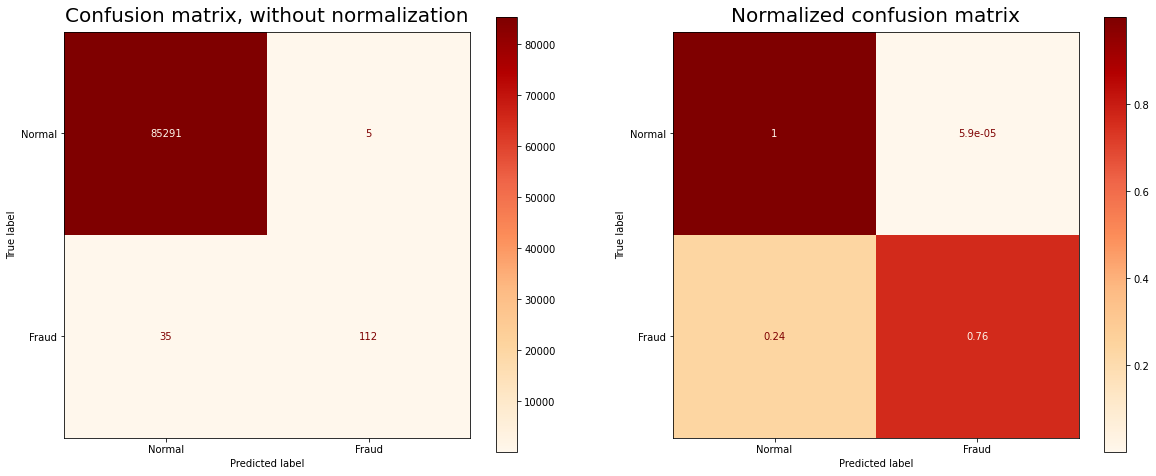

In [17]:
#Now let's check the real metrics for this classifier
from sklearn.metrics import plot_confusion_matrix


def print_confusion_matrix(model, X_test, y_test):
    """ Plot normalized and non-normalized confusion matrices """
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    fig, axes = plt.subplots(1,2,figsize=(20,8))
    for (title, normalize), ax in zip(titles_options, axes):

        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=["Normal", "Fraud"],
                                     cmap=plt.cm.OrRd,
                                     normalize=normalize,
                                     ax=ax)

        ax.set_title(title, fontsize=20, pad=10)

print_confusion_matrix(classifier_model, X_test, y_test)

## Synthetic data to improve the detection of fraud

### Synthetic data with YData synthesizer package

In this case the objective is to synthesize only the fraudulent events. Through the augmentation of fraudulent events we are able to improve the results the results of our classifier.

In [149]:
#Let's filter by fraudulent events only
aux = X_train.copy()
aux['y'] = y_train.reset_index()['Class']

non_fraud = aux[aux['y'] == 0]
fraud = aux[aux['y']==1]

del aux

In [ ]:
#Have here YData's lib to be called and used in the Jupyter Notebook
from ydata.synthesizers.regular import RegularSynthesizer

fraud_synth = RegularSynthesizer()
fraud_synth.fit(fraud)
synthetic_fraud = fraud_synth.sample(n_samples=400)

## Visualizing the generated synthetic data

In [173]:
#Read the synthetic fraud generated events 
#local_conn = LocalConnector()
#synthetic = local_conn.read_file('synthetic_fraud.csv', file_type=FileType.CSV)

synth_df = synthetic.copy()
org_df = X_train.copy()

org_df['Class'] = y_train.reset_index()['Class']
org_df['color'] = np.where(org_df['Class']==1, 2, 1)

synth_df['Class'] = synthetic['y']
synth_df = synth_df.drop('y', axis=1)
synth_df['color'] = 3

full_data = pd.concat([org_df, synth_df])

Using a PCA we are able to  reduce the dimensionality of the dataset and and better visualize the relation between both the synthetic fraud generated events and the ones from the original data, regardless they're fraud or normal events. 

The randomness introduced by the synthetic data can help the model to generalize for a new dataset and new fraud events never previously observed.

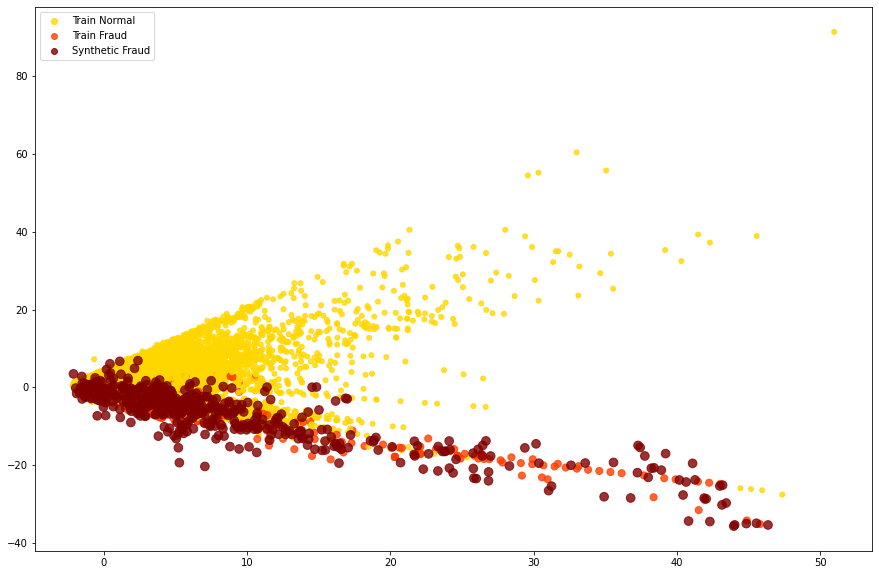

In [189]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = full_data.iloc[:, :-2]
color = full_data['color']

fig = plt.figure(1, figsize=(15, 10))
plt.clf()
plt.cla()

cmap = m.cm.jet(np.linspace(0,1,26))
cmap = m.colors.ListedColormap(cmap[17:,:-1])

pca = PCA(n_components=2)
projected = pca.fit_transform(X)

labels = ['Train Normal', 'Train Fraud', 'Synthetic Fraud']

size_map = {1:25, 2:50, 3:75}
sizes = [size_map[x] for x in color]

scatter = plt.scatter(projected[:, 0], projected[:, 1],
                      s=sizes,
                      c=color,
                      cmap=cmap, 
                      alpha=0.8)

plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()

### Testing the classifier capacity after adding more fraudulent events

In [190]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([85296,   147]))

In [163]:
synth_y_train = synthetic['y']
synth_train = synthetic.drop('y', axis=1)

X_augmented = pd.concat([X_train, synth_train], axis=0)
y_augmented = pd.concat([y_train, synth_y_train], axis=0)

In [164]:
synth_classmodel, y_pred = XGBoost_Classifier(X_augmented, y_augmented, X_test)

Start fitting XGBoost classifier
Classifier trained.


In [191]:
# Print precision / recall report
print('Overall accuracy score :',accuracy_score(y_test, y_pred))
print('Classifier performance report: ')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

Overall accuracy score : 0.9995786664794073
Classifier performance report: 
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85296
       Fraud       0.92      0.83      0.87       147

    accuracy                           1.00     85443
   macro avg       0.96      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



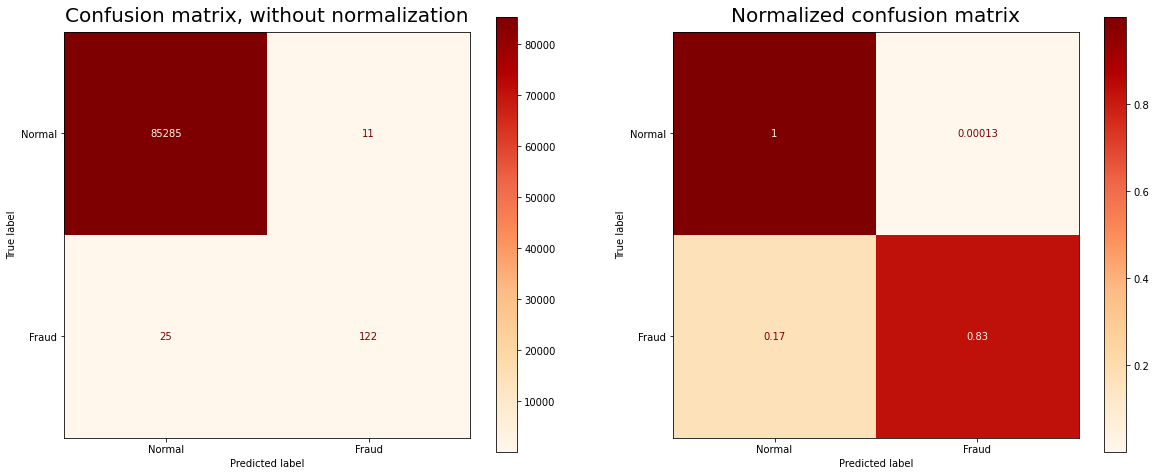

In [165]:
print_confusion_matrix(synth_classmodel, X_test, y_test)